In [1]:
import pandas as pd
import torch
from IPython.lib.editorhooks import emacs
from fontTools.misc.iterTools import batched

In [2]:
df = pd.read_csv("images/metadata/images.csv")

In [3]:
df.head()

,image_id,height,width,path
0,010-mllS7JL,106,106,14/14fe8812.jpg
1,01dkn0Gyx0L,122,122,da/daab0cad.jpg
2,01sUPg0387L,111,111,d2/d2daaae9.jpg
3,1168jc-5r1L,186,186,3a/3a4e88e6.jpg
4,11RUV5Fs65L,30,500,d9/d91ab9cf.jpg


In [10]:
df = df[(df["height"] > 1000) & (df["width"] > 1000)]
df["path"] = "images/small/" + df["path"]

In [11]:
df.head()

,image_id,height,width,path
554,21LlmxUCtTS,1080,1920,images/small/46/4689906d.png
6627,41+7D+3hkuL,1200,1200,images/small/68/6839db4e.jpg
6644,41+DJcA2xrL,1050,1050,images/small/55/5584aeeb.jpg
6661,41+Ri5xhAfL,1001,1001,images/small/75/7527736c.jpg
6669,41+XT8ItV3L,1050,1050,images/small/1a/1a02ed5e.jpg


In [7]:
from sentence_transformers import SentenceTransformer
from PIL import Image

In [13]:
model = SentenceTransformer("clip-ViT-B-32")

In [22]:
img_emb = model.encode(Image.open("images/small/46/4689906d.png"))
img_emb.shape

(512,)

vector length -> 512 \
ViT -> Vision Transformer\
B -> size, basically medium -> Tiny << Small << Base << Large\
32 -> patch size in pixels used by ViT to encode

In [23]:
from sqlalchemy.engine import URL
from typing import List
from pgvector.sqlalchemy import Vector
from sqlalchemy import Integer, String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column

In [62]:
class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))

In [63]:
from sqlalchemy import create_engine

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db"
)


engine = create_engine(db_url)

In [64]:
Base.metadata.create_all(engine)

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [66]:
from itertools import islice


def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 2) → AB CD EF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch

In [67]:
image_paths = list(df["path"])

In [73]:
import joblib
from PIL import Image
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session

MAX_IMAGES = 20_000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

def insert_images(engine, images):
    with Session(engine) as session:
        for image in images:
            session.add(image)
        session.commit()


def vectorize_images(engine, model, image_paths, i=2):
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths[MAX_IMAGES*i:MAX_IMAGES*(i+1)], BATCH_SIZE):
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = [Img(image_path=images_paths_batch[i], embedding=embeddings[i]) for i in range(len(images_paths_batch))]

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(imgs))

vectorize_images(engine, model, image_paths)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [69]:
import matplotlib.pyplot as plt
from sqlalchemy import select

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images(found_images.scalars().all())

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description)

        # remember about session and commit
        query = (
            # write query to find K images with highest cosine distance
            select(Img)
            .order_by(Img.embedding.cosine_distance(image_embedding))
            .limit(k)
        )
        with Session(self.engine) as session:
            result = session.execute(query, execution_options={"prebuffer_rows": True})

        return result

    def display_images(self, images):
        k = len(images)
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, image in enumerate(images):
            img = Image.open(image.image_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")

        plt.show()

## MAX_IMAGES = 20_000

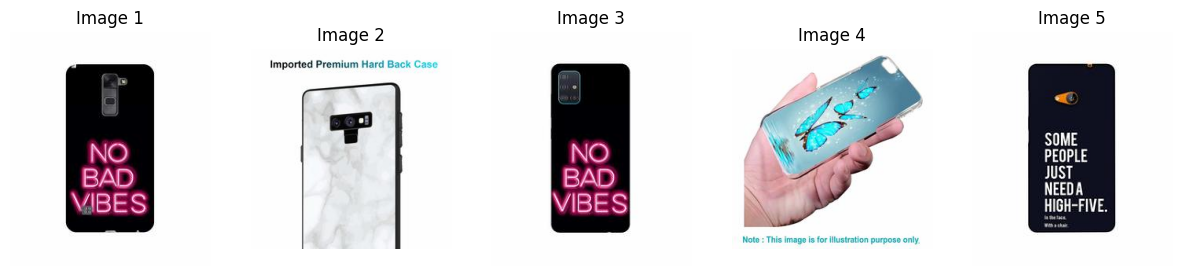

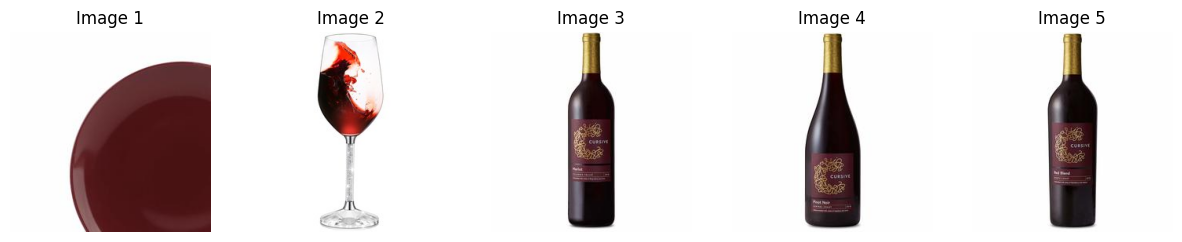

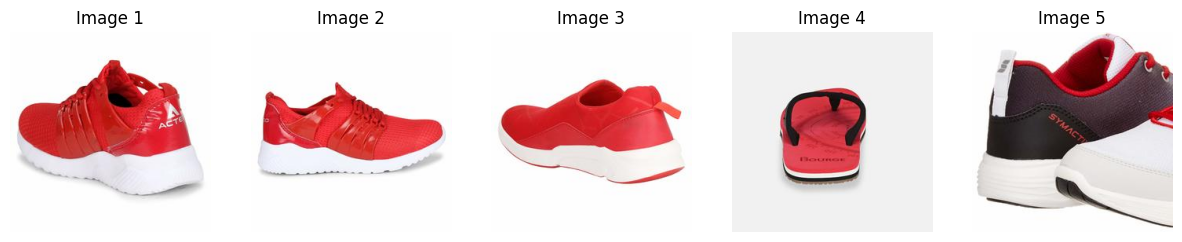

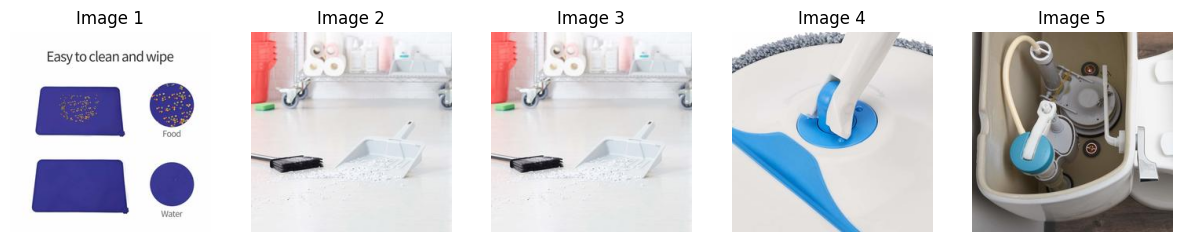

In [70]:
image_search = ImageSearch(engine, model)
image_search("custom phone case", 5)
image_search("luxurious red wine", 5)
image_search("running boots very fast and red yes", 5)
image_search("detergent to clean the kitchen", 5)

## MAX_IMAGES = 40_000

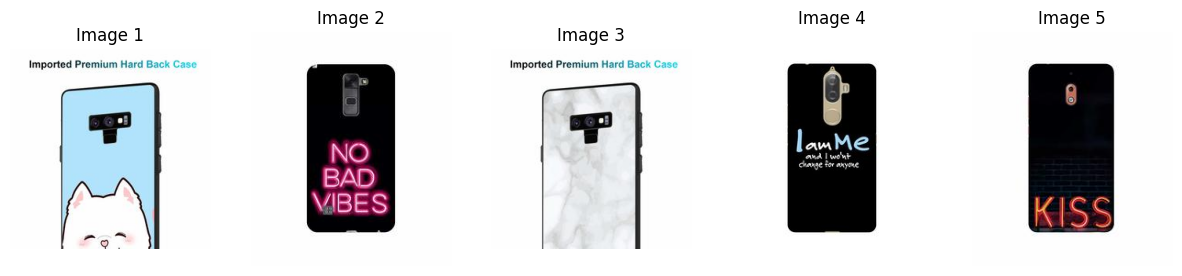

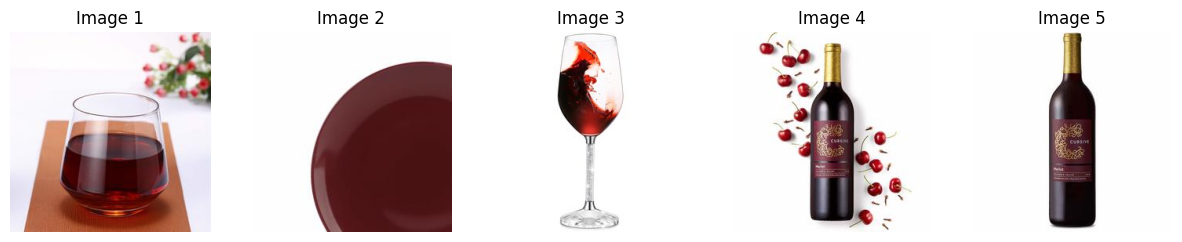

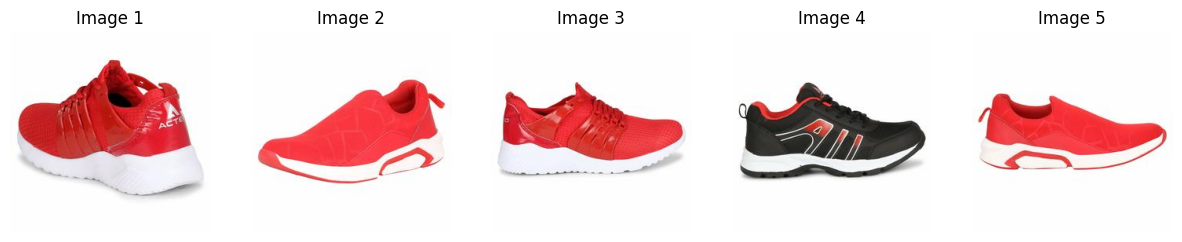

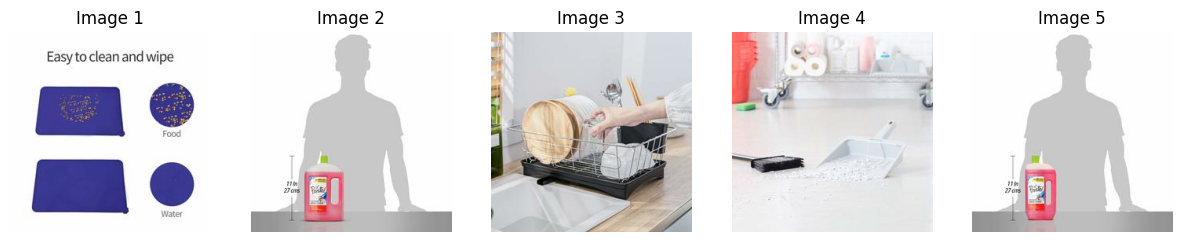

In [72]:
image_search = ImageSearch(engine, model)
image_search("custom phone case", 5)
image_search("luxurious red wine", 5)
image_search("running boots very fast and red yes", 5)
image_search("detergent to clean the kitchen", 5)

## MAX_IMAGES = 60_000

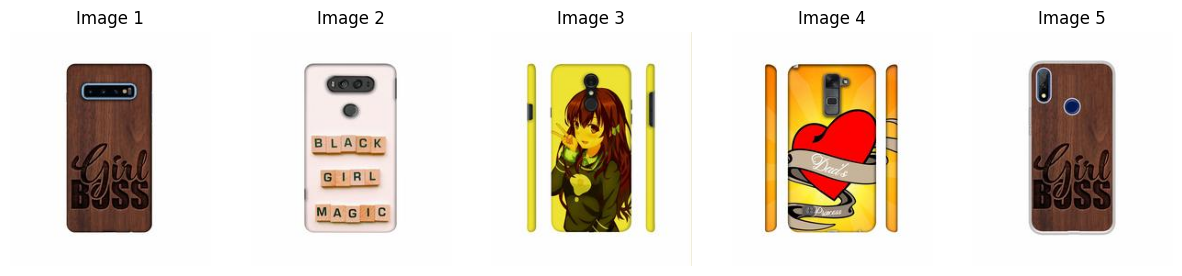

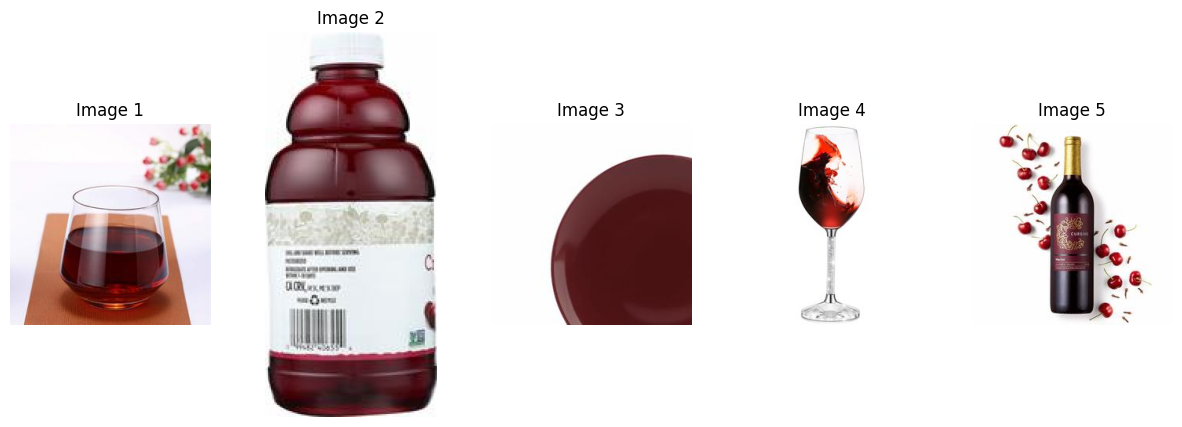

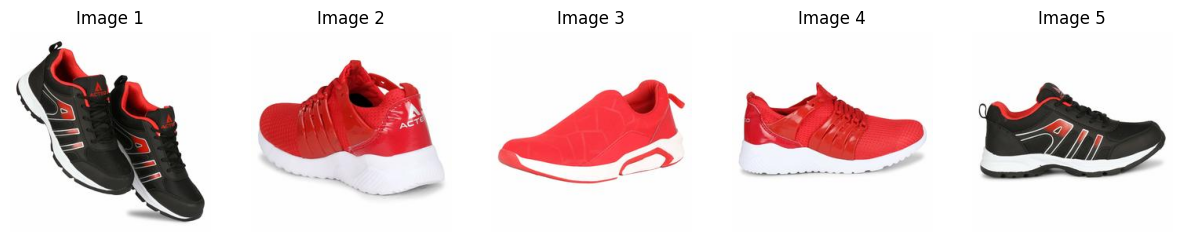

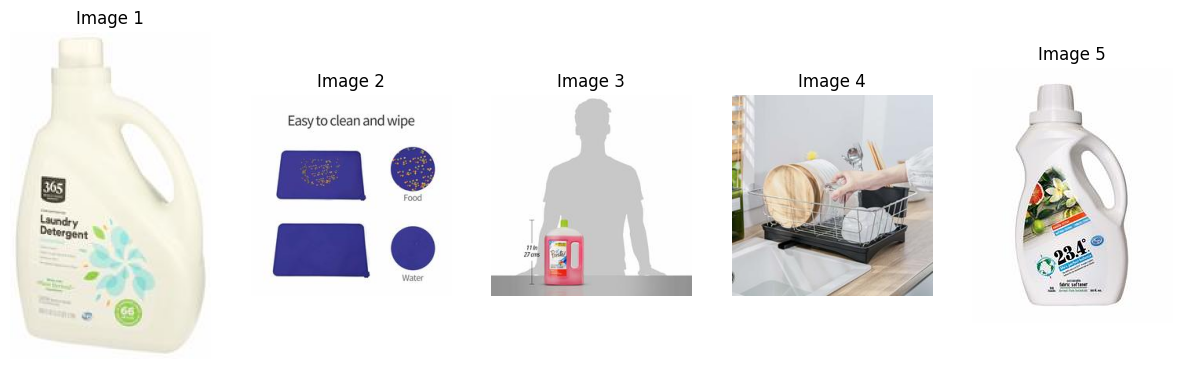

In [78]:
image_search = ImageSearch(engine, model)
image_search("custom phone case", 5)
image_search("luxurious red wine", 5)
image_search("running boots very fast and red yes", 5)
image_search("detergent to clean the kitchen", 5)

The more embeddings the better (interesting that wines images got corrupted)